# Investment analytics tutorial

A couple of first points:
    
1. Thank you for being here
2. This is an opportunity to learn together and share best practices and preferences, not a lecture
3. I am here on a voluntary basis, delighted to be here, and will remain available in the future if I can assist you:
m.a.agachi[at]gmail.com
4. Tutorial covers investment analytics as used in practice by many investment firms. Designed for a beginner to
intermediary level audience wishing to implement them in python/pandas. What motivated this tutorial.
5. Python packages and pandas still lack many functions used in finance. Where this is the case, we will implement them manually here.
6. As we are a data science community, I will comment the code/packages/functions here and there.
7. My usual rant on open data

What is an investment?

> Investment is an initial forfeit of something we value in exchange for the anticipated 
> benefit of getting back more than we put in. The differ- ence between what we put in and 
> what we got back is the return; we invest in order to yield this return.

> Bruce Feibel

Why investment analytics?

These are your road indicators as an investor in the alternative space. Without robust analysis you are blind, as an investor and as an allocator.

Three key drivers:

1. Few people in the industry know these concepts inside out
2. Can help industry with its identity crisis
3. A move towards quality of performance rather than just performance

What are investment analytics? 

The study of time series. Everything you do as an operator on the markets in finance 
is time dependent. Time is a constraint in your input, and a determinant of your output. These statistics are time sensitive.

> "The calculation of return, risk, and derived statistics stemming from the periodic change 
> in market value of portfolio positions and transactions made into and within a portfolio, 
> for use in the evaluation of historical fund or manager performance."

> Bruce Feibel

Backward looking or forward looking?

The same for all asset classes and strategies?

Overview:
1. Performance and basic statistical concepts
2. Risk adjusted performance analysis
3. Skill and performance attribution

## Performance and basic statistical concepts - The value of time

Key question in this section - How has the value of the portfolio changed over time

In [6]:
#let's import our packages
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import math
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
%matplotlib inline

In [7]:
#cd Dropbox/Investment performance analysis presentation/presentation

You can download this dataset at this following address:
http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html

You will then need to open it and save it as a csv on your computer, renaming the file "S&P 500.csv"

Many thanks to Aswath Damodaran, not only for this dataset but more generally for his terrific ressources, openly available.

In [19]:
sp500 = pd.read_csv("S&P 500.csv")

In [20]:
sp500.head()

,Year,Date,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,1928,43.81%,NaN,NaN,NaN
1,1929,-8.30%,NaN,NaN,NaN
2,1930,-25.12%,NaN,NaN,NaN
3,1931,-43.84%,NaN,NaN,NaN
4,1932,-8.64%,NaN,NaN,NaN


In [21]:
#let's get rid of the extra columns getting created in the conversion process
sp501 = sp500[['Year', 'Date']]

In [22]:
sp501.head()

,Year,Date
0,1928,43.81%
1,1929,-8.30%
2,1930,-25.12%
3,1931,-43.84%
4,1932,-8.64%


In [23]:
#let's turn the percentages, which pandas now reads as strings, into floats
returns = [float(x[:-1]) for x in sp501['Date']]

In [24]:
sp501['Date'] = returns

/Users/iht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
sp501.columns = ['Year', 'Value']

In [26]:
sp501.head()

,Year,Value
0,1928,43.81
1,1929,-8.30
2,1930,-25.12
3,1931,-43.84
4,1932,-8.64


In [27]:
sp501['Year'] = pd.to_numeric(sp501['Year'], errors='coerce')

/Users/iht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
sp501['Value'] = pd.to_numeric(sp501['Value'])

/Users/iht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


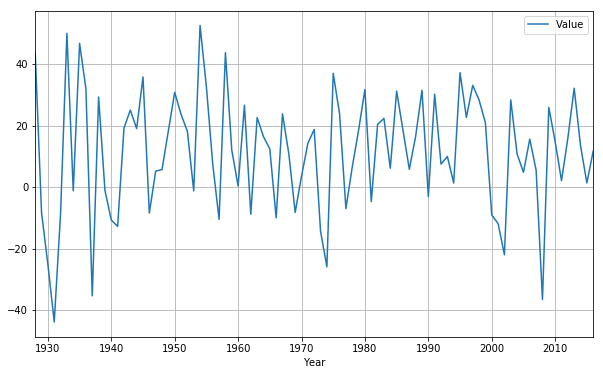

In [34]:
#Let's take a peek at the annual returns of the S&P 500 since 1928
sp501.set_index('Year').plot(figsize=(10,6), grid=True)

In [35]:
#average returns
sp_average_return = sp501['Value'].mean()
sp_average_return

11.415842696629218

Two concepts around the mean:
    
1. Arithmetic mean

2. Geometric mean

$arithmetic \ mean \ return = \frac{sum\ of\ returns\ across\ periods}{number \ of \ periods}$

$geometric\ mean\ return = (\sqrt[N]{(1+cumulative\ return)} - 1) * 100$

In [36]:
#let's write a function to calculate the geometric mean

def geomean(x):
    product = 1
    for i in x:
        product *= (1 + i/100)
    return ((product ** (1 / len(x)))-1) * 100

geometric_mean = geomean(sp501['Value'])
geometric_mean

9.525016349238058

Why is the geometric mean lower than the arithmetic mean?

Because of compound interest. With the arithmetic mean, you are measuring the average on compound interest too, so you are overvaluing your returns. The geometric mean corrects for that effect, providing a lower average return.

Two more concepts to discuss: Time weighted vs Money weighted value of an investment

1. The investor who could not understand why his AUM are not as high as a fund's returns would suggest.

2. Why investors rarely make as much money on their investments as funds' returns would suggest.

Which one are we focusing on here and why?

On investment analytics, we focus on time weighted of an investment. Because we compare products or portfolios, and we want to isolate the effect of the manager. You going to remove the money weighted value of the investment. If a product has a much higher money volume, it would be over represented in the comparison.

! Bank Administration Institute, Measuring the Investment Performance of Pension Funds for the Purpose of Inter-Fund Comparison, Bank Administration Institute, Park Ridge, Illinois 1968.

In [38]:
#Now we have the mean return over this period. Can we therefore expect such a return next year?
#Let's look at the range of the one year rolling returns of the S&P 500 over this period?

sp_average_max = sp501['Value'].max()
sp_average_min = sp501['Value'].min()
sp_average_min, sp_average_max

(-43.840000000000003, 52.560000000000002)

The answer would be no. We observe a very large variation - what measure would allow us to capture this?

Standard deviation

The standard deviation represents how far, in average, the observations were from their observed mean.
In finance it is the fundamental concept of volatility.

Three problems with the standard deviation.

1. Often wrongly used.

**It is not a measure of risk, but an indication of consistency over time (periods).**

Two funds with 20 years track records:
    a. average returns of -5% and vol of 1
    b. average returns of 10% and vol of 7

In [39]:
two_funds = pd.read_csv("Two funds.csv")
two_funds

,Year,Fund A,Fund B
0,2012,5,10
1,2013,5,0
2,2014,5,10
3,2015,5,0
4,2016,5,10
5,2017,5,0


In [40]:
sp_average_std = sp501['Value'].std()
sp_average_std

19.702879162527395

Question: can volatility ever be negative, and if so under what circumstances?

No. Volatilyt measures movement, movements can be negative, but volatility is either zero (no movement at all), or positive because there are movements.

In investing and therefore in risk analytics, time is always a parameter. Let's see how.

Go to 
https://finance.yahoo.com/quote/^GSPC/history?period1=1348700400&period2=1506466800&interval=1d&filter=history&frequency=1d
and download the historical prices for the S&P 500, daily and monthly. In this tutorial the date range was September 26 2012-September 26 2017

I kept here the files' original names.

In [43]:
sp500_daily = pd.read_csv('GSPC_daily.csv')
sp500_monthly = pd.read_csv('GSPC_monthly.csv')

In [44]:
sp500_daily.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-26,1441.599976,1441.599976,1430.530029,1433.319946,1433.319946,3565380000
1,2012-09-27,1433.359985,1450.199951,1433.359985,1447.150024,1447.150024,3150330000
2,2012-09-28,1447.130005,1447.130005,1435.599976,1440.670044,1440.670044,3509230000
3,2012-10-01,1440.900024,1457.140015,1440.900024,1444.489990,1444.489990,3505080000
4,2012-10-02,1444.989990,1451.520020,1439.010010,1445.750000,1445.750000,3321790000


In [45]:
# The shift function allows us to shift all values up or down in a column.

sp500_daily['daily_returns'] = sp500_daily['Adj Close'] / sp500_daily['Adj Close'].shift(1)-1
sp500_daily.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,daily_returns
0,2012-09-26,1441.599976,1441.599976,1430.530029,1433.319946,1433.319946,3565380000,NaN
1,2012-09-27,1433.359985,1450.199951,1433.359985,1447.150024,1447.150024,3150330000,0.009649
2,2012-09-28,1447.130005,1447.130005,1435.599976,1440.670044,1440.670044,3509230000,-0.004478
3,2012-10-01,1440.900024,1457.140015,1440.900024,1444.489990,1444.489990,3505080000,0.002652
4,2012-10-02,1444.989990,1451.520020,1439.010010,1445.750000,1445.750000,3321790000,0.000872


In [47]:
sp500_daily_vol = sp500_daily['daily_returns'].std()
sp500_daily_vol_annualized = sp500_daily_vol * math.sqrt(252) # annualized std, market is open for 252 days a year
sp500_daily_vol, sp500_daily_vol_annualized

(0.007668116862563054, 0.12172758145513618)

In [48]:
sp500_monthly.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-01,null,null,null,null,null,null
1,2012-10-01,1440.900024,1470.959961,1403.280029,1412.160034,1412.160034,71752320000
2,2012-11-01,1412.199951,1434.270020,1343.349976,1416.180054,1416.180054,71489310000
3,2012-12-01,1416.339966,1448.000000,1398.109985,1426.189941,1426.189941,66388180000
4,2013-01-01,1426.189941,1509.939941,1426.189941,1498.109985,1498.109985,75848510000


In [49]:
sp500_monthly['Adj Close'] = pd.to_numeric(sp500_monthly['Adj Close'], errors = 'coerce')

In [50]:
sp500_monthly['monthly_returns'] = sp500_monthly['Adj Close'] / sp500_monthly['Adj Close'].shift(1)-1
sp500_monthly.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,monthly_returns
0,2012-09-01,null,null,null,null,NaN,null,NaN
1,2012-10-01,1440.900024,1470.959961,1403.280029,1412.160034,1412.160034,71752320000,NaN
2,2012-11-01,1412.199951,1434.270020,1343.349976,1416.180054,1416.180054,71489310000,0.002847
3,2012-12-01,1416.339966,1448.000000,1398.109985,1426.189941,1426.189941,66388180000,0.007068
4,2013-01-01,1426.189941,1509.939941,1426.189941,1498.109985,1498.109985,75848510000,0.050428


In [51]:
sp500_monthly_vol = sp500_monthly['monthly_returns'].std()
sp500_monthly_vol_annualized = sp500_monthly_vol * math.sqrt(12)
sp500_monthly_vol, sp500_monthly_vol_annualized

(0.02720897718750704, 0.09425466182148945)

What do we learn from this? Time is always an input in finance. Volatility should always be reported with the time scale (daily, monthly, etc)

not revaluing your portfolio too often can lead to a low vol strategy

p.s. it can also lead to absolute, uncorrelated returns, especially in times of crisis

Our statistics are highly time dependant including in terms of inputs

We are sitting now with a mean that is accompanied by a relatively high volatility.

How do we get a more accurate picture of the long term averages?

Longer rolling returns periods. This smoothes the values over. This is also why some funds prefer basing their performance fees on rolling returns.

Let's smoothe

In [52]:
sp501["3yr rolling mean"] = sp501['Value'].rolling(window = 3, center=False).mean()
sp501["10yr rolling mean"] = sp501['Value'].rolling(window = 10, center=False).mean()

/Users/iht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/iht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


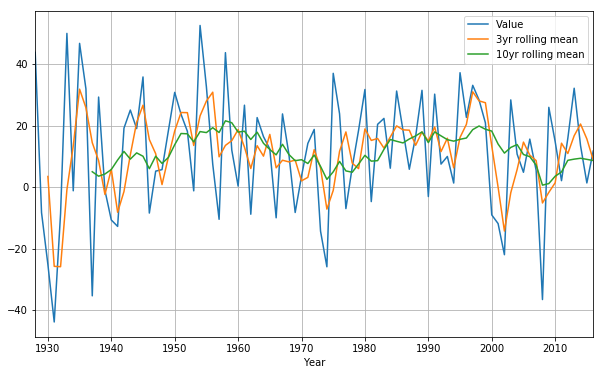

In [54]:
sp501.set_index('Year').plot(figsize=(10,6), grid=True)

In [56]:
sp501.head(12)

,Year,Value,3yr rolling mean,10yr rolling mean
0,1928,43.81,NaN,NaN
1,1929,-8.30,NaN,NaN
2,1930,-25.12,3.463333,NaN
3,1931,-43.84,-25.753333,NaN
4,1932,-8.64,-25.866667,NaN
5,1933,49.98,-0.833333,NaN
6,1934,-1.19,13.383333,NaN
7,1935,46.74,31.843333,NaN
8,1936,31.94,25.830000,NaN
9,1937,-35.34,14.446667,5.004


In [57]:
sp501['3yr rolling mean'].max()

31.84333333333333

In [58]:
sp501['10yr rolling mean'].max()

21.559000000000001

Second issue: The standard deviation assumes normality of the distribution. What is a normal distribution?

About 68% of the observed returns will be within a range of one standard deviation above and 
below the mean return.

■ Approximately 90% of returns within ±1.65 standard deviations.

■ Approximately 95% of returns within ±2 standard deviations.

■ Almost all returns within ±3 standard deviations.

Are historical returns of S&P500 normally distributed?

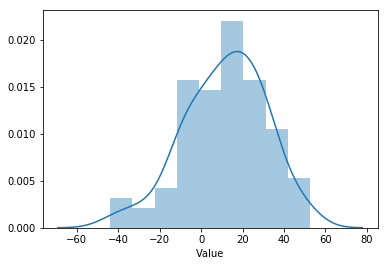

In [59]:
sns.distplot(sp501['Value'])

In [60]:
#Quick tip: If it is normally distributed, the mean and the median should be the same.
sp501['Value'].mean(), sp501['Value'].median()

(11.415842696629218, 13.52)

What allows us to describe the shape of a distribution more precisely?

The third and fourth moments of a distribution. Skewness and Kurtosis.

Skewness (3rd moment): the degree of asymmetry of a distribution around its mean. Negative or left skewness means an asymmetric left tail that extends more towards negative values than its right counterparty. And vice-versa. In a negatively skewed distribution, the mean will be lower than the median, and the standard deviation will underestimate the proportion of returns below the mean and overestimate the proportion of returns above the mean.

Kurtosis (4th moment): degree of peakness of a distribution. Normal distribution is 3. A lower value indicates a flatter distribution or platykurtic and a higher value a more peaked, or leptokurtic distribution. A higher value implies more returns closer to the mean than for the normal distribution, and therefore also fatter tails i.e. more high values in the tails than we would otherwise expect.

! Skewness and kurtosis are not measured in units of return.

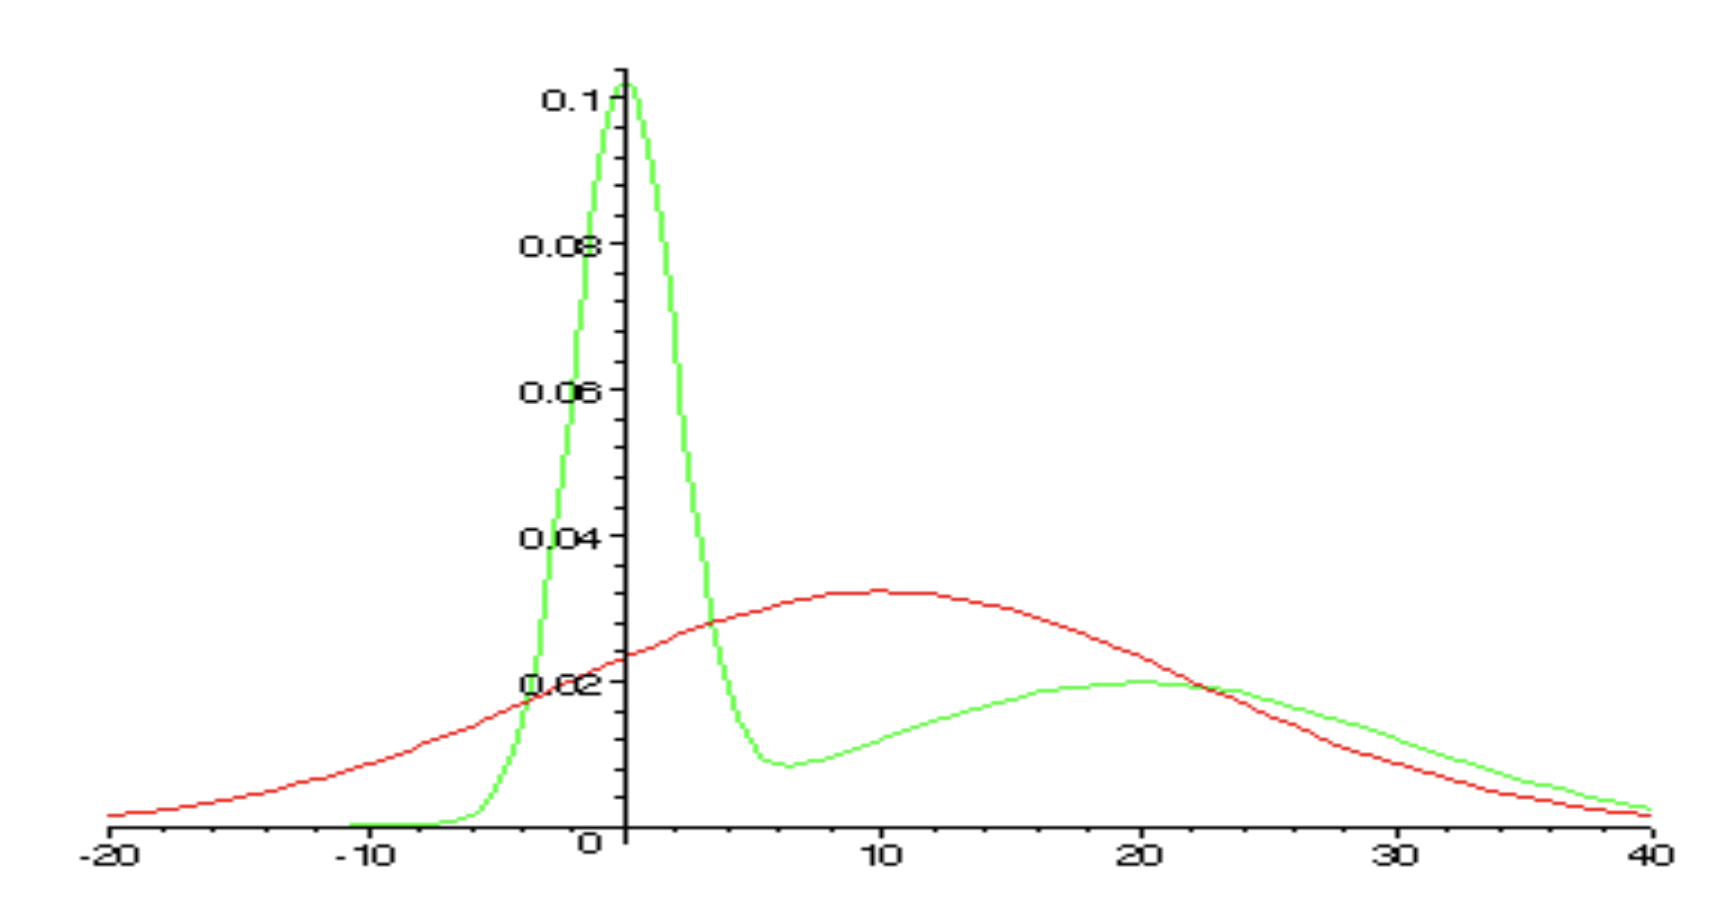

In [61]:
from IPython.display import Image
from IPython.core.display import HTML 
Image("Two_distributions.png")

In [62]:
#Many thanks to Con Keating for kindly providing this illustration.

Skewness

Formula for calculating the skewness:
$\sum (\frac {x_i - \overline x}{stdev(x_i)}) ^ 3 * \frac{1}{N}$

In [63]:
skewness = sp501['Value'].skew()
skewness

-0.40401800741280103

Negative skewness? What do we do now?

Kurtosis: same formula as skewness, but we raise to the power of 4 instead of 3

Formula for calculating the skewness:
$\sum (\frac {x_i - \overline x}{stdev(x_i)}) ^ 4 * \frac{1}{N}$

In [64]:
kurtosis = sp501['Value'].kurtosis()
kurtosis

0.088679683721088143

!The kurtosis function in pandas returns the excess kurtosis actually, not the kurtosis itself.
In this case, we have a slightly higher kurtosis and therefore fat tails i.e. frequency of outcomes in the tails, at the extremes, is higher than we would expect based on a normal distribution.

How do we test for both/for normality?

Jarque-Bera test.

Named after Carlos Jarque and Anil Bera.

Compares skewness and kurtosis to what would be expected for a normal distribution i.e. a skewness of 0 and an excess kurtosis of 0.
Deviation from either one will increase its value. If greater than 6, usually a sign that distribution is not normal.

Formula:

$(skewness^2 + \frac {excess \ kurtosis^2}{4}) * \frac{N}{6}$

In [65]:
#scipy offers a jarque bera test function

scipy.stats.jarque_bera(sp501['Value'])

(2.3410325018531082, 0.31020675539609432)

In [67]:
scipy.stats.shapiro(sp501.Value)

(0.9837073087692261, 0.3299134075641632)

The $p$-value is 0.33 > 0.05, so we cannot reject the null hypothesis that the data is not normal, in spite of previous evidences.

What can we conclude?

# Risk
The financial crisis and ensuing recession from a risk perspective

The "Our risk models were wrong" and "We did not understand risk" arguments

Risk analytics is impossible in a probabilistic universe?

Risk analysts/modelling experts are palm readers?

I believe this to be an oversimplification/wrong.

You misestimate risk by using the wrong distribution, or the wrong value for your stdev. The problem is simple - the solution may not be.

First of all, what is risk? Several definitions of risk
1. The risk of losing money i.e. absolute risk
2. The risk of not achieving a minimal return i.e. internal relative risk
3. The risk of deviating from a benchmark too much i.e. external relative risk

Questions we are trying to answer:

How much risk does the portfolio manager take to achieve a certain return?

How much uncertainty surrounds our expected return from this portfolio?

Volatility/Return relationship. See Ibbotson Associates research on these.

Risk measurement vs risk management.

Measures we will review here:

Absolute risk: dev; MAR

Relative risk: correlation; Sharpe; Sortino; Information Ratio

Some of the issues with the stdev:

1. Two funds can have the same historical returns with widely different standard deviations. A fund can consistently lose money and have a significantly lower standard deviation than a fund annualizing high returns.
2. The standard deviation is calculated around the historical mean.
3. Units
4. The standard deviation places the same emphasis on upside and downside deviations from the mean. We are usually only wary of downside deviation, while warmly welcoming the upside one.

Question: can you compare two funds based on the standard deviation of their returns?

Standardization

The coefficient of variation

In [75]:
coef_variation = sp501['Value'].std()/sp501['Value'].mean()
coef_variation

1.7259241990383338

Partial moments - measure part of the distribution

A lower partial moment: the semideviation. The stdev of returns that fall below the mean return.

$ semideviation = \sqrt(\frac{\sum(x_i - \overline x) ^2 where (x_i < \overline x)}{N})$

In [76]:
mean = sp501['Value'].mean()
def semidev(x):
    if x < mean:
        return x
    else:
        return 0

In [77]:
sp501['Negative deviation'] = sp501['Value'].apply(semidev)

In [78]:
sp501.head(5)

,Year,Value,3yr rolling mean,10yr rolling mean,Negative deviation
0,1928,43.81,NaN,NaN,0.00
1,1929,-8.30,NaN,NaN,-8.30
2,1930,-25.12,3.463333,NaN,-25.12
3,1931,-43.84,-25.753333,NaN,-43.84
4,1932,-8.64,-25.866667,NaN,-8.64


In [79]:
def semidev2(x):
    if x != 0:
        return (x - mean)**2
    else:
        return 0

In [80]:
sp501['semidev2'] = sp501['Negative deviation'].apply(semidev2)
sp501.head(5)

,Year,Value,3yr rolling mean,10yr rolling mean,Negative deviation,semidev2
0,1928,43.81,NaN,NaN,0.00,0.000000
1,1929,-8.30,NaN,NaN,-8.30,388.714453
2,1930,-25.12,3.463333,NaN,-25.12,1334.867802
3,1931,-43.84,-25.753333,NaN,-43.84,3053.208152
4,1932,-8.64,-25.866667,NaN,-8.64,402.236826


In [81]:
semideviation = math.sqrt(sp501['semidev2'].sum()/len(sp501))
semideviation

14.61720072842248

Question: can the semideviation and standard deviation be the same?

Issue mentioned: standard deviation and semideviation are both relative to their own means.

What about deviation from an absolute return?

Downside measures that are not calculated around the historical mean are particularly helpful and informative when we don't deal with a normal distribution.

Concept of MAR.

Shortfall risk: percentage of returns that fall below target return

$shortfall= \frac{number \ of \ returns < target \ return}{total \ number \ of \ returns}$

In [82]:
shortfall_risk = len([x for x in sp501['Value'] if x < 5])/len(sp501)*100
shortfall_risk

33.70786516853933

What about the magnitude of the downside deviation when it does happen?

Expected downside value

$expected \ downside = \frac{\sum x_i - target \ return \ where \ x_i < target \ return}{N}$

In [83]:
expected_downside_value = sum([(x-5) for x in sp501['Value'] if x < 5])/len(sp501)
expected_downside_value

-5.2238202247191019

## Now looking at relative risk.
Relative to what?

Concept of benchmark

> Practitioners have come to accept that a peer group universe does not fulfill all of the requirements for a good 
> measure of relative performance. Jeffrey Bailey set out the criteria of a good performance comparison benchmark, 
> which is “unambiguous, investable, measurable, appropriate, and specified in advance.” 

> Jeffrey Bailey

Overall, two types of benchmarking:
1. To a standard i.e. index
2. To your peer group

Significantly easier/standardized in some asset classes than others for example.

"But, what I do is so special and unique and wonderful that I don't have a benchmark..."

Silly.

In [85]:
#Download monthly returns for period 2015-2016 from Barclay Hedge Fund Index:

#https://www.barclayhedge.com/research/indices/ghs/Hedge_Fund_Index.html

#Many thanks to Barclay Hedge for making this data publicly available.

#copy monthly returns for S&P 500 for those two years in the same file as the Barclay Hedge Fund Index

returns = pd.read_csv("Hedge Fund Index vs SP 500 returns.csv")
returns.head(24)

,Unnamed: 0,Popular hedge fund index,S&P 500
0,30-01-15,-0.10,-3.10
1,28-02-15,2.20,5.49
2,30-03-15,0.42,-1.74
3,30-04-15,1.08,0.85
4,30-05-15,0.81,1.05
5,30-06-15,-1.09,-2.10
6,30-07-15,-0.55,1.97
7,30-08-15,-2.50,-6.26
8,30-09-15,-1.69,-2.64
9,30-10-15,2.22,8.30


In [86]:
returns.set_index(returns['Unnamed: 0'], inplace = True)
returns.columns

Index(['Unnamed: 0', 'Popular hedge fund index', 'S&P 500'], dtype='object')

In [87]:
returns.drop('Unnamed: 0', axis = 1, inplace=True)

In [89]:
returns.head()

,Popular hedge fund index,S&P 500
Unnamed: 0,,
30-01-15,-0.10,-3.10
28-02-15,2.20,5.49
30-03-15,0.42,-1.74
30-04-15,1.08,0.85
30-05-15,0.81,1.05


In [103]:
%pylab inline
sns.set()
sns.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


/Users/iht/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


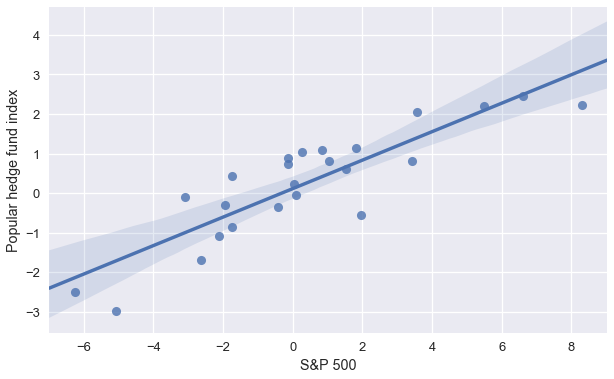

In [106]:
#let's visualize the two return streams, keeping an eye open for association
returns_copy = returns.copy()
returns_copy.columns = ["hedgeFundIndex", "SP500"]
plt.figure(figsize=(10,6))
sns.regplot(x='S&P 500', y = 'Popular hedge fund index', data = returns)

What does this dispersion tell us? How else could it look?

Covariance. Powerful but of limited use by itself.

What is correlation?

Amount by which two return streams vary together. Correlation captures the direction and magnitude of this variation.

Formula:

$Correlation \ = \ \frac {covariance}{stdev \ (fund \ returns) * stdev \ (benchmark \ returns)}$

In [107]:
correlation = returns.corr()
correlation

,Popular hedge fund index,S&P 500
Popular hedge fund index,1.000000,0.877012
S&P 500,0.877012,1.000000


Issues with correlation as a measure:

Easy to interpret at its extremes, but much fuzzier when the value is somewhere in the middle of the possible range.

By the way, what is its range of possible values?

What is the rule of thumb for being "uncorrelated" in applied investing?

Normally, under 0.3 is called undercorrelated.

Idea: apply bootstrapping to estimate the distribution of correlation coefficientes across a set of known funds? That could give values to set thresholds to consider if a fund is correlated or not to an index.

In [109]:
#Coefficient of determination
#square of the correlation coefficient
#easier to interpret: proportion of portfolio returns that can be explained by variability in benchmark returns
r_squared = 0.877012**2
r_squared

0.769150048144

How do you interpret it?

What is the range of its possible values?

What is the coefficient of nondetermination?

## Alpha and beta

What is alpha?

Alpha remains an elusive concept.

Identifiable, in a strict sense, via a classic linear regression analysis.
Average fund return = alpha + beta * average benchmark return

What is beta?

Magnitude of variability in fund returns, given variability in benchmark returns.

In [110]:
formula = "hedgeFundIndex ~ SP500"
test1 = smf.ols(formula, data = returns_copy).fit()
print(test1.summary())

                            OLS Regression Results                            
Dep. Variable:         hedgeFundIndex   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     73.30
Date:                Sat, 14 Oct 2017   Prob (F-statistic):           1.88e-08
Time:                        16:41:14   Log-Likelihood:                -24.173
No. Observations:                  24   AIC:                             52.35
Df Residuals:                      22   BIC:                             54.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1115      0.142      0.784      0.4

In the example above, you cannot say if the alpha (intercept) is different than zero, as the confidence interval contains zero. The test assume that the data is normally distributed. If it is not normal, it should be tested by a non-parametric method, e.g. bootstrapping.

What does this beta tell us?
Is it high or low?

!A higher beta implies that the fund has taken on more benchmark relative risk.
How do we read the alpha and beta here?

Why bother with the beta if we have the correlation already?

Question: if a fund has a very high beta, does that mean that its returns are roughly similar to those of the benchmark?

What does a beta of 1 mean?

In [111]:
#Alpha
alpha = 0.1115
annualized_alpha = (1+alpha)**12 - 1
annualized_alpha

2.555605787383672

In [ ]:
#Check the following
#https://www.evestment.com/resources/investment-statistics-guide/relative-risk-adjusted-return-measures-and-annualized-alpha/
#https://admainnew.morningstar.com/webhelp/glossary_definitions/mutual_fund/glossary_all_Alpha.html

An aside through the long only world

$tracking \ risk = stdev(mean \ fund \ return)* \sqrt(1-(correlation)^2)$

In [112]:
tracking_risk = returns['Popular hedge fund index'].std() * math.sqrt(1-((pearsonr(returns['Popular hedge fund index'], returns['S&P 500']))[0])**2)
tracking_risk

0.6767632235864324

In [113]:
#Annualized tracking risk
tracking_risk * math.sqrt(12)

2.3443765758915935

When and why bother with tracking risk?

Degree of difference in fund returns and benchmarl returns over time.

Units?

# Moving on to relative risk/return measures

Concept: systematic vs unsystematic risk.

The Sharpe ratio, a risk adjusted measure of excess return

Instead of only measuring return, it measures excess return per unit of deviation of an investment's returns

Key concept: with summary metrics in general you are trying to capture more (relevant) information in your metric

Formula:

$Sharpe = \frac{annual \ mean \ fund \ return - annual \ mean \ risk \ free \ return}{annualized \ stdev}$

What is a risk free investment? How to choose a proxy for it here?

In [117]:
# Here the return has not been corrected for risk (returns_copy['SP500'] is the returns including the risk/volatility)

sharpe = (returns_copy['hedgeFundIndex'].mean() - returns_copy['SP500'].mean()) / (returns_copy['hedgeFundIndex'].std())
sharpe * math.sqrt(12)

-0.3648023383666347

!attention - while our returns are monthly here, we should have used the annual means in the Sharpe and not the monthly ones
we annualized following a standard annualization technique but this only holds in special circumstances
See: http://www.edge-fund.com/Lo02.pdf

In [118]:
returns_copy.head(5)

,hedgeFundIndex,SP500
Unnamed: 0,,
30-01-15,-0.10,-3.10
28-02-15,2.20,5.49
30-03-15,0.42,-1.74
30-04-15,1.08,0.85
30-05-15,0.81,1.05


What do you think of this Sharpe ratio?

What do you think of its two major drawbacks?

1. Penalizes upside and downside deviation equally. Few of us will be upset over a much higher performance than average last month

2. If you were trying to increase your Sharpe, how would you do it? Hint: look at the formula carefully.

What if instead of returns to absolute risk, we want to look at returns relative to systematic/market risk?

We use beta as a proxy of market risk: the Treynor ratio. Instead of using the stdev in the denominator, as with the Sharpe ratio, we use beta i.e. market risk.

Formula:
$Treynor = \frac{mean \ fund \ return - mean \ risk \ free \ return}{beta}$

In [119]:
treynor = (returns_copy['hedgeFundIndex'].mean() - returns_copy['SP500'].mean()) / 0.36
treynor

-0.412037037037037

A harsher measure of risk adjusted return: the Sortino ratio

created by Dr Frank Sortino of the Pension Research Institute

a modification of sharpe ratio: downside deviation as denominator and target return subtracted in numerator

Interpretation: excess return to downside risk

$Sortino = \frac{(mean \ fund \ return - target \ return) * P}{\sqrt \frac {\sum (fund \ return - T) ^2 if \ fund \ return < T}{N}* \sqrt P}$

It is using the downside deviation instead of the standard dev., compared to the Sharpe ratio

In [120]:
t = 1.1
def sortino_step_1(x):
    if x < t:
        return x
    else: 
        return 0

In [121]:
returns_copy['sortino_step_1'] = returns_copy['hedgeFundIndex'].apply(sortino_step_1)

In [122]:
def sortino_step_2(x):
    if x != 0:
        return (x-t) ** 2
    else:
        return 0

In [123]:
returns_copy['sortino_step_2'] = returns_copy['sortino_step_1'].apply(sortino_step_2)
returns_copy['sortino_step_2']

Unnamed: 0
30-01-15     1.4400
28-02-15     0.0000
30-03-15     0.4624
30-04-15     0.0004
30-05-15     0.0841
30-06-15     4.7961
30-07-15     2.7225
30-08-15    12.9600
30-09-15     7.7841
30-10-15     0.0000
30-11-15     0.7744
30-12-15     3.8416
30-01-16    16.7281
28-02-16     2.1025
30-03-16     0.0000
30-04-16     0.0049
30-05-16     0.2304
30-06-16     1.2996
30-07-16     0.0000
30-08-16     0.1369
30-09-16     0.0441
30-10-16     1.9881
30-11-16     0.0784
30-12-16     0.0000
Name: sortino_step_2, dtype: float64

In [124]:
sortino = ((returns_copy['hedgeFundIndex'].mean() - t) * 12) / (math.sqrt(returns_copy['sortino_step_2'].sum()/len(returns_copy)) * math.sqrt(12))
sortino

-1.8849430134045686

As a rule of thumb, when is Sortino higher than Sharpe and vice versa?

Information ratio

Active return divided by tracking error

The benchmark linked return relative to benchmark linked risk

Formula:

$Annualized \ IR = \frac{ \frac{\sum(fund \ return_i - benchmark \ return_i)}{N} * \sqrt P}{stdev(fund \ return \ i - market \ return \ i) * \sqrt P}$

In [125]:
ir = ((returns_copy['hedgeFundIndex'] - returns_copy['SP500']).sum()/len(returns_copy) * math.sqrt(12)) / ((returns_copy['hedgeFundIndex'] - returns_copy['SP500']).std()*math.sqrt(12))
ir

-0.06462367033338945

Next step - something few people undertake. Test of significance of such a result.

t statistic of value added - was it significant or not?

based on statistical hypothesis test

null hypothesis

alternative hypothesis

How is the information ratio read?
What does a negative information ratio mean?

$t \ statistic \ of \ value \ added = \frac{Average (fund \ return - benchmark \ return)}{stdev \ of \ (average \ fund \ return - average \ benchmark \ return) / \sqrt N}$

In [126]:
t_statistic = ((returns_copy['hedgeFundIndex'] - returns_copy['SP500']).mean())/((returns_copy['hedgeFundIndex'] - returns_copy['SP500']).std() / math.sqrt(len(returns_copy)))
t_statistic

-0.316590035245278

Can the t value be negative?
What do we do with this?

## Efficiency, skill, and attribution

Mean PnL

Mean Hold

Batting average

Win/Loss ratio

In [127]:
#the following sections use data from a previous live model
#Many thanks to Clarus Risk for providing this data.

pnl = pd.read_csv("PnL_20170831.csv")
pnl.head()

,Position,Start,End,Days,Side,price1,price2,PnL,alpha,Pnl>0,PosPnL,NegPnL,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,AALBERTS INDUSTRIES,2/19/16,6/16/16,82,1,31.9264,31.7362,0.60,5.998586,True,0.599316,NaN,NaN,Trade Statistic,Value,Recc,NaN,NaN
1,AALBERTS INDUSTRIES,6/23/16,7/6/16,9,1,28.8045,34.2914,-16.00,-12.186828,False,NaN,16.000805,NaN,# Trades,527.00,527.00,NaN,NaN
2,ABBOTT LABORATORIES CMN,6/28/16,9/12/16,53,1,41.4200,37.5600,10.28,10.097234,True,10.276890,NaN,NaN,Mean PnL%,0.69,0.69,NaN,NaN
3,ACCENTURE PLC CMN,11/23/15,1/4/16,21,1,101.8300,107.8400,-5.57,-0.743019,False,NaN,5.573071,NaN,Mean Hold (Days),37.57,37.57,NaN,0.69
4,ACS ACTIVIDADES DE CONST.Y SERVICIOS SA,1/4/16,2/24/16,37,-1,23.7335,27.9679,15.14,-0.695100,True,15.140214,NaN,NaN,Batting Average%,45.35,45.35,NaN,NaN


In [128]:
pnl = pnl.iloc[:, 0:9]
pnl.head()

,Position,Start,End,Days,Side,price1,price2,PnL,alpha
0,AALBERTS INDUSTRIES,2/19/16,6/16/16,82,1,31.9264,31.7362,0.60,5.998586
1,AALBERTS INDUSTRIES,6/23/16,7/6/16,9,1,28.8045,34.2914,-16.00,-12.186828
2,ABBOTT LABORATORIES CMN,6/28/16,9/12/16,53,1,41.4200,37.5600,10.28,10.097234
3,ACCENTURE PLC CMN,11/23/15,1/4/16,21,1,101.8300,107.8400,-5.57,-0.743019
4,ACS ACTIVIDADES DE CONST.Y SERVICIOS SA,1/4/16,2/24/16,37,-1,23.7335,27.9679,15.14,-0.695100


In [129]:
pnl['Days'].describe()

count    527.000000
mean      37.565465
std       46.789015
min        1.000000
25%        7.000000
50%       19.000000
75%       45.000000
max      279.000000
Name: Days, dtype: float64

In [130]:
#Average holding period (days)
pnl['Days'].mean()

37.56546489563567

In [131]:
#Mean PnL (%)
pnl['PnL'].mean()

0.6944022770398481

Now let's calculate the batting average

Why bother with the BA and the WL ratio?

BA: the number of investments that have achieved a positive PnL, versus the total number of investments made. Similar to sports.

WL ratio: the ratio between how well positions with a positive PnL performed, vs how badly positions with a negative PnL performeed, in average.

BA is an indicator of a fund's research and investment analysis skills.
WL ratio is an indicator of a fund's portfolio construction/management skills i.e. how it manages its winning and losing positiong.

!Unlike most investment statistics, these can be meaningfully compared across strategies, asset classes, and funds.

!Novus has found that BA and WL ratio are more persistent statistics than most others regarding a fund's performance profile, and they attribute this to their focus on the nature of the investment process itself. They explain this as most return analysis statistics are a function of returns, while the BA/WL are drivers of returns. As such, they are less dependant on exogenous factors than returns.

In [132]:
def ba(x):
    if x > 0:
        return "True"
    else:
        return "False"
pnl['pnl > 0'] = pnl['PnL'].apply(ba)
pnl.head()

,Position,Start,End,Days,Side,price1,price2,PnL,alpha,pnl > 0
0,AALBERTS INDUSTRIES,2/19/16,6/16/16,82,1,31.9264,31.7362,0.60,5.998586,True
1,AALBERTS INDUSTRIES,6/23/16,7/6/16,9,1,28.8045,34.2914,-16.00,-12.186828,False
2,ABBOTT LABORATORIES CMN,6/28/16,9/12/16,53,1,41.4200,37.5600,10.28,10.097234,True
3,ACCENTURE PLC CMN,11/23/15,1/4/16,21,1,101.8300,107.8400,-5.57,-0.743019,False
4,ACS ACTIVIDADES DE CONST.Y SERVICIOS SA,1/4/16,2/24/16,37,-1,23.7335,27.9679,15.14,-0.695100,True


In [133]:
batting_average = len(pnl[pnl['pnl > 0'] == "True"]) / len(pnl)
batting_average

0.45351043643263755

In [134]:
#now let's get to W/L ratio
def positive_pnl(x):
    if x >= 0:
        return x
    else:
        return 0
def negative_pnl(x):
    if x < 0:
        return abs(x)
    else:
        return 0

In [135]:
pnl['positive_PnL'] = pnl['PnL'].apply(positive_pnl)
pnl['negative_PnL'] = pnl['PnL'].apply(negative_pnl)
pnl.head()

,Position,Start,End,Days,Side,price1,price2,PnL,alpha,pnl > 0,positive_PnL,negative_PnL
0,AALBERTS INDUSTRIES,2/19/16,6/16/16,82,1,31.9264,31.7362,0.60,5.998586,True,0.60,0.00
1,AALBERTS INDUSTRIES,6/23/16,7/6/16,9,1,28.8045,34.2914,-16.00,-12.186828,False,0.00,16.00
2,ABBOTT LABORATORIES CMN,6/28/16,9/12/16,53,1,41.4200,37.5600,10.28,10.097234,True,10.28,0.00
3,ACCENTURE PLC CMN,11/23/15,1/4/16,21,1,101.8300,107.8400,-5.57,-0.743019,False,0.00,5.57
4,ACS ACTIVIDADES DE CONST.Y SERVICIOS SA,1/4/16,2/24/16,37,-1,23.7335,27.9679,15.14,-0.695100,True,15.14,0.00


In [136]:
win_loss_ratio = pnl['positive_PnL'].mean() / pnl['negative_PnL'].mean()
win_loss_ratio

1.2316359148020364

## Performance attribution

> "Quantification of the sources of fund, benchmark, and benchmark relative value added."

> Bruce Feibel

■ What was the manager's relative skill in selecting securities?

■ What was the manager's relative skill in selecting market segments?

■ How was the manager correlated to the different investment styles?

Main methods used:

1. Style attribution
A decomposition based on active risk factor exposures. Typical model: Fama-French framework, value, momentum, size, market.
2. Return decomposition
A decomposition based on active weights. Many flavors, but typical one includes security selection, allocation, and interaction.

In what cases should you use one over the other?

A brief overview of Brinson attribution
BHB vs BF models.

Style attribution data:
    
http://us.spindices.com/indices/equity/sp-500-value

In [87]:
brinson = pd.read_csv('brinson_attribution.csv')
brinson.head(5)

,Sector,Net Port Weight%,Bench Weight%,Bench Sector Weight,Bench Sector Return,Portfolio Sector Weight (Long)%,Portfolio Sector Weight (Short)%,Porfolio Return Long,Portfolio Return Short
0,Consumer Discretionary,2.33,12.15,12.1461,0.0049,14.6369,-12.3063,-0.0040,0.0023
1,Consumer Staples,0.56,9.33,9.3314,0.0019,2.1062,-1.5497,0.0056,0.0050
2,Energy,1.63,5.88,5.8823,0.0055,1.6256,0.0000,-0.0010,0.0000
3,Financials,11.32,18.00,18.0013,0.0036,11.3228,0.0000,0.0035,0.0000
4,Health Care,0.11,12.29,12.2863,0.0152,3.3389,-3.2260,0.0200,0.0148


In [88]:
brinson['allocation_long'] = (brinson['Portfolio Sector Weight (Long)%'] - brinson['Bench Weight%']) * brinson['Bench Sector Return']
brinson['allocation_short'] = (brinson['Portfolio Sector Weight (Short)%'] - brinson['Bench Weight%']) * brinson['Bench Sector Return']
brinson['allocation'] = brinson['allocation_long'] - brinson['allocation_short']
brinson['allocation']

0     0.132022
1     0.006946
2     0.008941
3     0.040762
4     0.099786
5     0.056452
6     0.099488
7     0.055401
8     0.030201
9     0.000000
10    0.026531
Name: allocation, dtype: float64

In [89]:
brinson['selection_long'] = (brinson['Porfolio Return Long'] - brinson['Bench Sector Return']) * brinson['Bench Weight%']
brinson['selection_short'] = (brinson['Portfolio Return Short'] - brinson['Bench Sector Return']) * brinson['Bench Weight%']
brinson['selection'] = brinson['selection_long'] - brinson['selection_short']
brinson['selection']

0    -0.076545
1     0.005598
2    -0.005880
3     0.063000
4     0.063908
5     0.038556
6     0.170448
7    -0.002535
8     0.011951
9     0.000000
10    0.003310
Name: selection, dtype: float64

In [90]:
brinson['interaction_long'] = (brinson['Portfolio Sector Weight (Long)%'] - brinson['Bench Weight%'])*(brinson['Porfolio Return Long'] - brinson['Bench Sector Return'])
brinson['interaction_short'] = (brinson['Portfolio Sector Weight (Short)%'] - brinson['Bench Weight%'])*(brinson['Portfolio Return Short'] - brinson['Bench Sector Return'])
brinson['interaction'] = brinson['interaction_long'] - brinson['interaction_short']
brinson['interaction']

0    -0.085720
1     0.006999
2    -0.004686
3    -0.064132
4    -0.049172
5    -0.061335
6    -0.129326
7    -0.056834
8    -0.024415
9     0.000000
10   -0.016575
Name: interaction, dtype: float64

A couple of comments on attribution:

1. Attribution needs to match the manager style i.e. top down vs bottom up
2. BHB vs BF
3. Interaction effect remains elusive to interpret

Other measures:

Uniqueness

Overlap

Leverage

VaR

## To be continued - backtests

## Most common mistakes in risk analytics

Not understanding the units of a measure

Not understanding the period of a measure

Not understanding the concept behind a measure

## Bibliography and references

Adrian, Tobias, Markus Brunnermeier, and Hoai-Luu Nguyen. "Hedge Fund Tail Risk." (n.d.): n. pag. Web.

Altshuller, Stan. How to Analyze Manager Skill with Limited Transparency. Rep. Novus. N.p.: n.p., 2016. Print.

Altshuller, Stan. Which Hedge FundsAreWorth the High Fees? Which Hedge Funds Are Worth the High Fees?

Angelini, Luca, and Andrea Gentilini. Batting Average and Win-Loss Ratio Applications. 2015, Batting Average and Win-Loss Ratio Applications.

Bailey, David & Lopez de Prado, Marcos. (2014). The Deflated Sharpe Ratio: Correcting for Selection Bias, Backtest Overfitting, and Non-Normality. The Journal of Portfolio Management. 40. 94-107. 10.3905/jpm.2014.40.5.094.

Brinson, Gary P., L. Randolph Hood, and Gilbert L. Beebower. "Determinants of Portfolio Performance." Financial Analysts Journal 51.1 (1995): 133-38. Web.

DiBartolomeo, Dan. “Evaluating Active Manager Skill.” Oct. 2014, Webinar, Webinar.

Eling M., Schuhmacher F. (2006) Performance Measurement of Hedge Fund Indices - Does the Measure Matter?. In: Haasis HD., Kopfer H., Schönberger J. (eds) Operations Research Proceedings 2005. Operations Research Proceedings, vol 2005. Springer, Berlin, Heidelberg

Equity Performance Attribution. Rep. Morningstar. N.p.: Morningstar, 2011. Print.

Erickson, Darrin. Interpreting Performance Attribution. Rep. CFA Institute. N.p.: CFA Institute, 2011. Print.

Favre, Laurent, and Jose-Antonio Galeano. An Analysis of Hedge Fund Performance Using Loess Fit Regression. Tech. EDHEC Business School. N.p.: n.p., 2002. Print.

Feibel, Bruce J. Investment Performance Measurement. N.p.: John Wiley & Sons, 2003. Print.

Ferson, Wayne. Investment Performance Evaluation. Working paper no. CenFIS Working Paper 10-01. N.p.: Federal Reserve Bank of Atlanta, 2010. Print.

Gehin, Walter. A Survey of the Literature on Hedge Fund Performance. Rep. A Survey of the Literature on Hedge Fund Performance. N.p.: n.p., 2004. Print.

Gentilini, Andrea, and Stan Altshuller. Your Investment Decisions Are Based on the Wrong Metrics. 2015, Your Investment Decisions Are Based on the Wrong Metrics.

Heydt, Michael. Mastering Pandas for Finance. N.p.: Packt Limited, 2015. Print.

Hilton, Max. RiskMonitor Glossary. Rep. RiskMonitor Clarus Risk. N.p.: Clarus Risk, 2016. Print.

Illmer, Stefan. "Overview of Performance Attribution." N/A. Apr. 2010. Web.

Investment Performance, Analytics and Risk - Glossary of Terms. Rep. J.P. Morgan. N.p.: n.p., 2008. Print.

Investment Statistics Guide. Rep. Evestment. N.p.: n.p., n.d. Print.

Kidd, Deborah. Risk-Adjusted Performance Measures: A Case Study. Rep. CFA Institute. N.p.: CFA Institute, 2012. Print.

Ledoit, Oliver, and Michael Wolf. "Robust Performance Hypothesis Testing with the Sharpe Ratio." Journal of Empirical Finance 15.5 (2008): 850-59. Web.

Leerink, Bas, and Gerard Van Breukelen. Multi-Period Performance Attribution. Working paper no. Applied Paper No. 2015-01. Ortec Finance. N.p.: Ortec Finance Research Center, 2015. Print.

Lo, Andrew. Where Do Alphas Come From?: A New Measure of the Value of Active Investment Management. Rep. MIT. N.p.: n.p., 2007. Web.

Marty, Wolfgang. Portfolio Analytics: An Introduction to Return and Risk Measurement. N.p.: Springer International, 2013. Print.

Petajisto, Antti. "Active Share and Mutual Fund Performance." CFA Institute Event. 28 Oct. 2013. Lecture.

Ryan, Timothy. Time Matters in Performance Analysis. Rep. CFA Institute. N.p.: CFA Institute, 2010. Print.

Securing Investment Returns in the Long Run - GFRI teaching team at the University of Geneva
https://www.coursera.org/learn/investment-returns-long-run/lecture/g5VrE/performance-attribution-example
[on performance attribution]

The Journal of Performance Measurement: http://www.spauldinggrp.com/the-journal/

Till, Hillary. Measuring Risk-Adjusted Returns in Alternative Investments. Rep. EDHEC Business School. N.p.: n.p., 2006. Print.

Yuen, Raymond. "WORKSHOP FOR USING EXCEL FOR FINANCE PART 6." Web.

## Thanks to:
[none of these individuals have reviewed the present work, yet all taught me more than I can describe here]

Pr. Wicher Bergsma, LSE

Pr. Roy Henk, Kyoto University

Pr. Marco Cuturi, ENSAE

Raymond Yuen, who kindly shared some of his work with me and whose tutorials I highly recommend

Con Keating, who kindly authorised me to share some of his terrific work

Max Hilton and the entire team at Clarus Risk, which have built a premier investment analytics and risk firm, and who provide independent risk analytics on our own funds:
info@clarusrisk.com

## Legal disclaimer:
This tutorial reflects purely and solely my own personal opinions.
Empiric Capital and its affiliated companies have had no input to this tutorial.
Recipients should form their own assessment and take independent professional advice on the merits of investing in general and the legal, regulatory, tax and investment consequences and risks of so doing. In preparing this document, the author has relied upon and assumed, without independent verification, the accuracy and completeness of all information available from public sources or which was otherwise used in the preparation of this document. The author accepts no responsibility to any person for the consequences of any person placing reliance on the content of this document for any purpose.
No part of this tutorial is to be understood or used as investment advice.